## Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage
import scipy.stats
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.features

## Data Files

In [118]:
# geopackage vector data
nz = gpd.read_file('data/nz.gpkg')
nz_height = gpd.read_file('data/nz_height.gpkg')
world = gpd.read_file('data/world.gpkg')
cycle_hire = gpd.read_file('data/cycle_hire.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')

# raster data
src_elev = rasterio.open('output/elev.tif')
src_landsat = rasterio.open('data/landsat.tif')
src_grain = rasterio.open('output/grain.tif')

### Intersection Operations

* 'intersects' is a catch-all join that will include features that touch, cross or are within
* 'disjoint' is the opposite of intersects
* 'within'
* 'touches'

In [49]:
canterbury = nz[nz['Name'] == 'Canterbury']
canterbury_height = nz_height[nz_height.intersects(canterbury.geometry.iloc[0])]
canterbury_height

,t50_fid,elevation,geometry
4,2362630,2749,POINT (1378169.6 5158491.453)
5,2362814,2822,POINT (1389460.041 5168749.086)
6,2362817,2778,POINT (1390166.225 5169466.158)
7,2363991,3004,POINT (1372357.036 5172728.743)
8,2363993,3114,POINT (1372062.487 5173236.285)


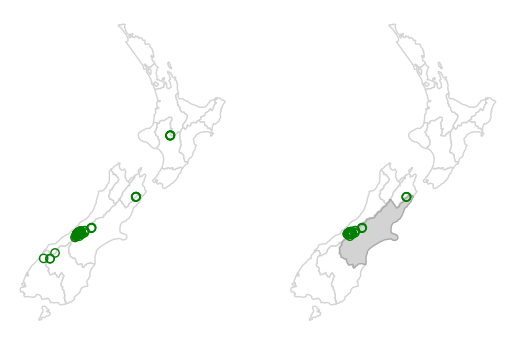

In [4]:
#
fig, ax = plt.subplots(1, 2)
nz.plot(ax = ax[0], color='white', edgecolor='lightgrey')
nz_height.plot(ax=ax[0], color='None', edgecolor='green')
ax[0].set_axis_off()

nz.plot(ax = ax[1], color='white', edgecolor='lightgrey')
canterbury.plot(ax=ax[1], color='lightgrey', edgecolor='darkgrey')
canterbury_height.plot(ax=ax[1], color='None', edgecolor='green')
ax[1].set_axis_off()
plt.show()

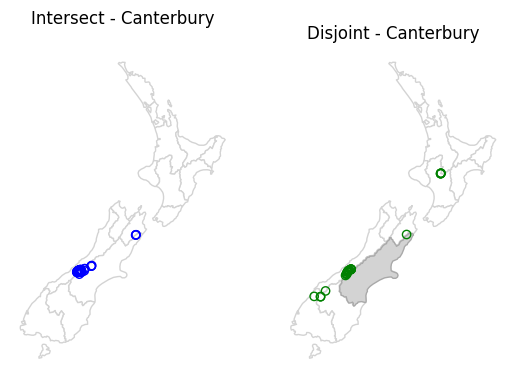

In [11]:
fig, ax = plt.subplots(1, 2)

canterbury_intersects = nz_height[nz_height.intersects(canterbury.geometry.iloc[0])]
nz.plot(ax = ax[0], color='white', edgecolor='lightgrey')
canterbury_intersects.plot(ax=ax[0], color='None', edgecolor='blue')
ax[0].set_title('Intersect - Canterbury')
ax[0].set_axis_off()

canterbury_disjoint = nz_height[nz_height.disjoint(canterbury.geometry.iloc[0])]
nz.plot(ax = ax[1], color='white', edgecolor='lightgrey')
canterbury.plot(ax=ax[1], color='lightgrey', edgecolor='darkgrey')
canterbury_distjoint.plot(ax=ax[1], color='None', edgecolor='green')
ax[1].set_title('Disjoint - Canterbury')
ax[1].set_axis_off()

plt.show()


### Relationships

With point and polygon examples

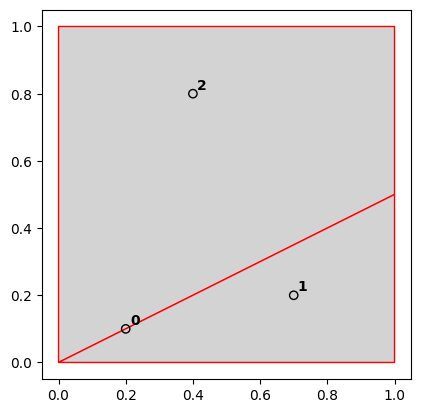

In [15]:
points = gpd.GeoSeries([
  shapely.Point(0.2,0.1), 
  shapely.Point(0.7,0.2), 
  shapely.Point(0.4,0.8)
])

line = gpd.GeoSeries([
  shapely.LineString([(0.4,0.2), (1,0.5)])
])

poly = gpd.GeoSeries([
  shapely.Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)])
])

poly2 = gpd.GeoSeries([
  shapely.Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)]),
  shapely.Polygon([(0,0), (1,0.5), (1,0), (0,0)])
])

base = poly2.plot(color='lightgrey', edgecolor='red')
points.plot(ax=base, color='none', edgecolor='black')
for i in enumerate(points):
    base.annotate(
        i[0], xy=(i[1].x, i[1].y), 
        xytext=(3, 3), textcoords='offset points', weight='bold'
    )

In [16]:
points.intersects(poly.iloc[0])

,0,1
0,True,True
1,False,True
2,True,False


In [17]:
points.within(poly.iloc[0])

0    False
1    False
2     True
dtype: bool

In [18]:
points.touches(poly.iloc[0])

0     True
1    False
2    False
dtype: bool

In [19]:
points.disjoint(poly.iloc[0])

0    False
1     True
2    False
dtype: bool

In [20]:
# Can also subset using distance relationships
points.distance(poly.iloc[0]) < 0.2

0    True
1    True
2    True
dtype: bool

### Spatial Joining

In [45]:
ht = nz_height.copy()
nzh = ht.sjoin(nz, how = 'left')
nzh = nzh[['Name', 'elevation']].groupby('Name').mean().reset_index()
nzh.columns = ['Name', 'mean_elevation']
nz2 = nz.merge(nzh, on = 'Name', how = 'outer')
nz2.head()

,Name,Island,Land_area,Population,Median_income,Sex_ratio,geometry,mean_elevation
0,Auckland,North,4941.572557,1657200.0,29600,0.944286,"MULTIPOLYGON (((1803822.103 5900006.143, 17914...",NaN
1,Bay of Plenty,North,12071.144689,299900.0,26200,0.928039,"MULTIPOLYGON (((2049387.29 5832785.434, 205101...",NaN
2,Canterbury,South,44504.499091,612000.0,30100,0.975327,"MULTIPOLYGON (((1686901.914 5353232.66, 167999...",2994.6
3,Gisborne,North,8385.826619,48500.0,24400,0.934973,"MULTIPOLYGON (((2024489.357 5674919.854, 20190...",NaN
4,Hawke's Bay,North,14137.524441,164000.0,26100,0.923838,"MULTIPOLYGON (((2024489.357 5674919.854, 20241...",NaN


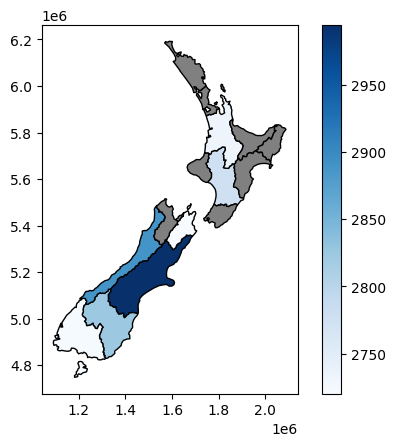

In [48]:
nz2.plot(
  column='mean_elevation', 
  legend=True,
  cmap='Blues', edgecolor='black',
  missing_kwds={'color': 'grey', 'edgecolor': 'black'}
)
plt.show()

### Grid Transfer Example: Incongruent Layers

Area-weighted transfer the properties of one geospatial object to another. In this example we're transferring the characteristics of the New Zealand data to an arbitrary grid.

In [68]:
# Settings: grid extent, resolution, and CRS
bounds = nz.total_bounds
crs = nz.crs
res = 100000
# Calculating grid dimensions
xmin, ymin, xmax, ymax = bounds
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax+res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax+res)), res))
rows.reverse()

# For each cell, create 'shapely' polygon (rectangle)
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([(x,y), (x+res, y), (x+res, y-res), (x, y-res)])
        )
        
# To 'GeoDataFrame'
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# Remove rows/columns beyond the extent
grid = grid[grid.intersects(shapely.box(*bounds))]

# Add consecutive IDs
grid['id'] = grid.index
grid

,geometry,id
0,"POLYGON ((1090143 6248536, 1190143 6248536, 11...",0
1,"POLYGON ((1090143 6148536, 1190143 6148536, 11...",1
2,"POLYGON ((1090143 6048536, 1190143 6048536, 11...",2
3,"POLYGON ((1090143 5948536, 1190143 5948536, 11...",3
4,"POLYGON ((1090143 5848536, 1190143 5848536, 11...",4
...,...,...
154,"POLYGON ((1990143 5248536, 2090143 5248536, 20...",154
155,"POLYGON ((1990143 5148536, 2090143 5148536, 20...",155
156,"POLYGON ((1990143 5048536, 2090143 5048536, 20...",156
157,"POLYGON ((1990143 4948536, 2090143 4948536, 20...",157


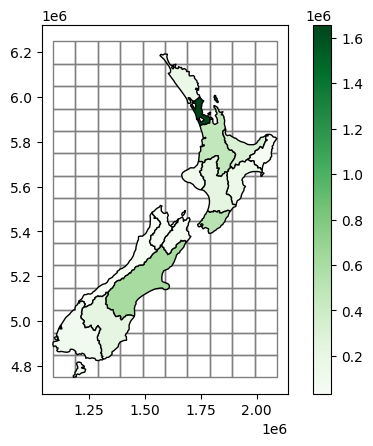

In [65]:
base = grid.plot(color='none', edgecolor='grey')
nz.plot(
    ax=base, 
    column='Population', 
    edgecolor='black', 
    legend=True, 
    cmap='Greens'
)
plt.show()

In [69]:
nz['area'] = nz.area
nz_grid = nz.overlay(grid)
nz_grid = nz_grid[['id', 'area', 'Population', 'geometry']]
nz_grid['area_sub'] = nz_grid.area
nz_grid['population'] = nz_grid['Population'] * (nz_grid['area_sub'] / nz_grid['area'])
nz_grid

,id,area,Population,geometry,area_sub,population
0,64,1.289058e+10,175500.0,"POLYGON ((1586362.965 6168009.001, 1568216.708...",3.231015e+08,4398.897141
1,80,1.289058e+10,175500.0,"POLYGON ((1590143 6162776.641, 1590143 6191701...",4.612641e+08,6279.925114
2,81,1.289058e+10,175500.0,"POLYGON ((1633099.964 6066188.094, 1632333.259...",5.685656e+09,77407.916241
3,82,1.289058e+10,175500.0,"POLYGON ((1688395.37 5989681.201, 1677965.696 ...",1.307476e+09,17800.759095
4,97,1.289058e+10,175500.0,"POLYGON ((1698281.254 6113546.125, 1698221.399...",2.013006e+09,27406.269178
...,...,...,...,...,...,...
105,87,1.046485e+10,46200.0,"MULTIPOLYGON (((1649908.695 5455398.241, 16565...",4.526248e+08,1998.239223
106,88,1.046485e+10,46200.0,"POLYGON ((1679241.14 5359477.533, 1667754.211 ...",7.223641e+09,31890.789070
107,89,1.046485e+10,46200.0,"POLYGON ((1641283.955 5341361.167, 1638347.722...",1.826943e+09,8065.550415
108,103,1.046485e+10,46200.0,"POLYGON ((1690724.332 5458875.452, 1698889.134...",1.227037e+08,541.709946


In [82]:
nz_grid = nz_grid.groupby('id')['population'].sum().reset_index()
ng = nz_grid.merge(grid, on='id', how='left')
ng = gpd.GeoDataFrame(ng)
ng.head()

,id,population,geometry
0,11,67.533590,"POLYGON ((1090143 5148536, 1190143 5148536, 11..."
1,12,15339.996965,"POLYGON ((1090143 5048536, 1190143 5048536, 11..."
2,13,22162.736308,"POLYGON ((1090143 4948536, 1190143 4948536, 11..."
3,14,311.884814,"POLYGON ((1090143 4848536, 1190143 4848536, 11..."
4,27,22465.184803,"POLYGON ((1190143 5148536, 1290143 5148536, 12..."


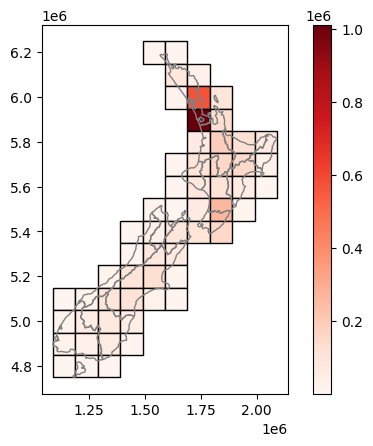

In [83]:
base = ng.plot(
    column='population', 
    edgecolor='black',
    legend=True, 
    cmap='Reds'
);
nz.plot(ax=base, color='none', edgecolor='grey', legend=True);

## Spatial Operations on Raster Data

In [84]:
src_elev.sample([0.1, 0.1])

<generator object sample_gen at 0x168e8c600>

In [87]:
list(src_elev.sample([(0.1, 0.1), (1.1, 1.1)]))

[array([16], dtype=uint8), array([6], dtype=uint8)]

### Masked Raster 


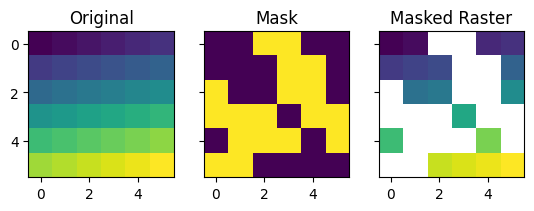

In [96]:
elev = src_elev.read(1)

np.random.seed(1)
mask = np.random.choice([True, False], src_elev.shape)

# create mask to filter raster values
masked_elev = elev.copy()
masked_elev = masked_elev.astype('float64')
masked_elev[mask] = np.nan

fig, ax = plt.subplots(1, 3, sharey = True)
rasterio.plot.show(elev, ax = ax[0]);
rasterio.plot.show(mask, ax = ax[1]);
rasterio.plot.show(masked_elev, ax = ax[2])
ax[0].set_title('Original')
ax[1].set_title('Mask')
ax[2].set_title('Masked Raster')
plt.show()

### NDVI Example

/var/folders/7w/smth_nxn7y767400txlm_s_c0000gn/T/ipykernel_1038/518652126.py:4: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir-red)/(nir+red)


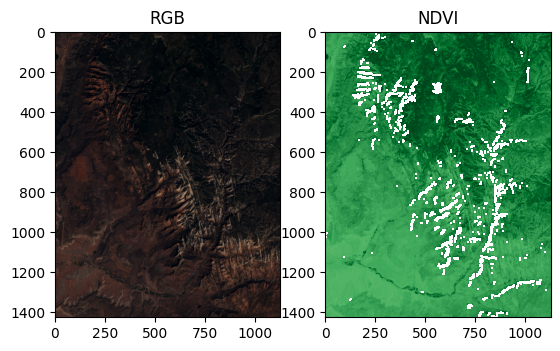

In [102]:
landsat = src_landsat.read()
nir = landsat[3]
red = landsat[2]
ndvi = (nir-red)/(nir+red)

landsat_rgb = landsat[:3][::-1] / landsat.max()

fig, ax = plt.subplots(1, 2)
rasterio.plot.show(landsat_rgb, cmap='RdYlGn', ax = ax[0])
rasterio.plot.show(ndvi, cmap='Greens', ax = ax[1])
ax[0].set_title('RGB')
ax[1].set_title('NDVI')
plt.show()

### Convolutional Operations

In [103]:
elev_min = scipy.ndimage.minimum_filter(elev, size=3)
elev_min

array([[ 1,  1,  2,  3,  4,  5],
       [ 1,  1,  2,  3,  4,  5],
       [ 7,  7,  8,  9, 10, 11],
       [13, 13, 14, 15, 16, 17],
       [19, 19, 20, 21, 22, 23],
       [25, 25, 26, 27, 28, 29]], dtype=uint8)

In [106]:
grain_mode = scipy.ndimage.generic_filter(
    src_grain.read(1), 
    lambda x: scipy.stats.mode(x.flatten())[0], 
    size=3
)
grain_mode = grain_mode.astype(float)
grain_mode[:, [0, -1]] = np.nan
grain_mode[[0, -1], :] = np.nan
grain_mode

array([[nan, nan, nan, nan, nan, nan],
       [nan,  0.,  0.,  0.,  2., nan],
       [nan,  0.,  0.,  0.,  1., nan],
       [nan,  1.,  1.,  1.,  1., nan],
       [nan,  1.,  1.,  1.,  1., nan],
       [nan, nan, nan, nan, nan, nan]])

### Use GDAL to Compute Slope and Aspect

In [109]:
# Can also do this via the CLI, though not with rasterio
os.system('gdaldem aspect output/srtm_32612.tif output/srtm_32612_aspect.tif')

0...10...20...30...40...50...60...70...80...90...100 - done.


0

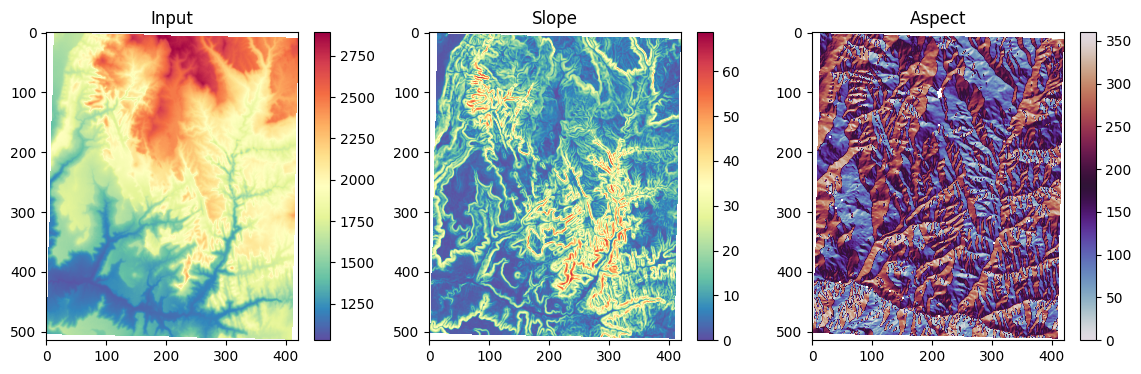

In [116]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4))


# Input DEM
src_srtm = rasterio.open('output/srtm_32612.tif')
srtm = src_srtm.read(1).astype(float)
srtm[srtm == src_srtm.nodata] = np.nan
rasterio.plot.show(src_srtm, cmap='Spectral_r', ax=ax[0])
fig.colorbar(ax[0].imshow(srtm, cmap='Spectral_r'))
ax[0].set_title('Input')

# Slope
src_srtm_slope = rasterio.open('output/srtm_32612_slope.tif')
srtm_slope = src_srtm_slope.read(1)
srtm_slope[srtm_slope == src_srtm_slope.nodata] = np.nan
rasterio.plot.show(src_srtm_slope, cmap='Spectral_r', ax=ax[1])
fig.colorbar(ax[1].imshow(srtm_slope, cmap='Spectral_r'))
ax[1].set_title('Slope')

# Aspect
src_srtm_aspect = rasterio.open('output/srtm_32612_aspect.tif')
srtm_aspect = src_srtm_aspect.read(1)
srtm_aspect[srtm_aspect == src_srtm_aspect.nodata] = np.nan
rasterio.plot.show(src_srtm_aspect, cmap='twilight', ax=ax[2])
fig.colorbar(ax[2].imshow(srtm_aspect, cmap='twilight'))
ax[2].set_title('Aspect')
plt.show()